#**桥水全天候策略**

# 参考资料

## 1. 网络资源
- **Bridgewater Associates** - [The All Weather Story](https://www.bridgewater.com/research-and-insights/the-all-weather-story)

## 2. 学术文献与专业书籍

### 风险平价理论基础
- **Roncalli, Thierry** - *Introduction to Risk Parity and Budgeting*

- **Spinu, Florin** - *An Algorithm for Computing Risk Parity Weights*

### 投资组合构建与优化
- **López de Prado, Marcos** - *Building Diversified Portfolios That Outperform Out-of-Sample*

- **Roncalli, Thierry et al.** - *Constrained Risk Budgeting Portfolios: Theory, Algorithms, Applications & Puzzles*

### 机器学习在金融中的应用
- **López de Prado, Marcos** - *Advances in Financial Machine Learning*

# All-Weather风险平价策略理论基础

## 1. 引言与数学框架

### 1.1 风险预算配置问题（Risk Budget Allocation Problem）
给定一个由N个金融资产构成的投资组合，其协方差矩阵为C，我们寻求一个满足以下条件的长仓、满仓投资组合：**每个资产对投资组合风险的贡献等于预先设定的权重**。

设投资组合权重向量为 $x = (x_1, \ldots, x_N)$，其中 $x_i > 0$ 表示投资于资产i的资本比例，且 $\sum_i x_i = 1$。

**投资组合风险**定义为收益率的标准差：
$$\sigma_P(x) := \sqrt{x^T C x}$$

### 1.2 边际风险贡献（Marginal Risk Contribution）
作为一次齐次函数，$\sigma_P(x)$ 满足欧拉恒等式：
$$\sigma_P = \sum_{i=1}^N x_i \frac{\partial \sigma_P}{\partial x_i}$$

资产i的**边际风险贡献**定义为：
$$MRC_i(x) := \frac{1}{\sigma_P} x_i \frac{\partial \sigma_P}{\partial x_i} = \frac{(Cx)_i x_i}{x^T C x}$$

注意 $\sum_i MRC_i = 1$。

### 1.3 风险预算投资组合的数学表述
**风险预算投资组合**是指每个资产的边际风险贡献匹配预定权重的投资组合：
$$MRC_i(x) = b_i$$

其中 $b_i > 0$ 是预定权重，$\sum_i b_i = 1$。

这等价于求解非线性方程组：
$$\sum_i |x_i| = 1, \quad (Cx)_i x_i = b_i x^T C x, \quad 1 \leq i \leq N$$

经过标量乘法变换，上述方程等价于：
$$Cx = b \oslash x$$

其中 $\oslash$ 表示逐元素除法，即 $(b \oslash x)_i = b_i / x_i$。

**风险平价（Risk Parity）**是风险预算配置的特殊情况，当 $b_i = \frac{1}{N}$ 时的解。

## 2. 经济环境四象限模型

### 2.1 理论框架
Ray Dalio提出，所有经济环境都可以用两个维度来描述：
- **经济增长**：相对于预期是上升还是下降
- **通胀水平**：相对于预期是上升还是下降

这构成了四个基本经济环境：

| 经济环境 | 增长 | 通胀 | 表现良好的资产类别 |
|---------|------|------|------------------|
| 上升增长 | ↑ | - | 股票、商品 |
| 下降增长 | ↓ | - | 债券、现金 |
| 上升通胀 | - | ↑ | 商品、通胀保护债券 |
| 下降通胀 | - | ↓ | 股票、债券 |

### 2.2 资产配置逻辑
```
环境配置 = {
    'RISING_GROWTH': ['股票指数', '商品', '黄金'],
    'FALLING_GROWTH': ['政府债券', '企业债券'],
    'RISING_INFLATION': ['商品', '黄金'],
    'FALLING_INFLATION': ['股票指数', '债券']
}
```

每个环境配置25%的风险预算，确保投资组合在任何经济环境下都能获得正收益。


## 3. 杠杆和波动率目标

### 3.1 传统资产配置的局限性
传统的资产配置方法（如60/40股债配置）存在以下问题：
- **风险集中**：尽管股票配置只有60%，但由于股票波动率远高于债券，实际上90%以上的投资组合风险来自股票
- **经济周期依赖**：在经济衰退或通胀高企时期，股债可能同时下跌，缺乏有效分散化
- **收益不稳定**：过度依赖单一资产类别的表现，导致收益波动较大

### 3.2 为什么需要杠杆？
风险平价投资组合通常波动率较低，主要原因：
- 大量配置低波动率资产（如债券）
- 分散化效应降低整体波动率

为了提升收益潜力，需要通过杠杆将波动率提升到目标水平，我们这里假设为15%。

### 3.3 杠杆计算
**杠杆倍数：**
$$L = \frac{\sigma_{target}}{\sigma_{portfolio}}$$

**杠杆后权重：**
$$w_{leveraged} = L \times w_{risk\_parity}$$

### 3.4 风险管理
- **目标波动率**：15%是平衡风险和收益的合理水平
- **借贷成本**：杠杆成本应接近无风险利率
- **再平衡频率**：定期重新计算权重，应对市场变化

## 4. 代码实现逻辑

### 4.1 分层优化方法
代码采用两层风险平价优化：

1. **环境内优化**：在每个经济环境内，对资产进行风险平价配置
2. **环境间优化**：对四个经济环境进行风险平价配置

这种方法确保：
- 同类资产间的风险平衡
- 不同经济环境间的风险平衡
- 整体投资组合的稳健性

### 4.2 核心算法流程
```python
# 步骤1：环境内风险平价
for environment in environments:
    cov_matrix = calculate_covariance(environment_assets)
    weights_within[environment] = risk_parity_optimization(cov_matrix)

# 步骤2：构建环境收益率
for environment in environments:
    env_returns[environment] = weighted_average(asset_returns, weights_within)

# 步骤3：环境间风险平价
env_cov_matrix = calculate_covariance(env_returns)
weights_between = risk_parity_optimization(env_cov_matrix)

# 步骤4：计算最终权重
final_weights = weights_within × weights_between

# 步骤5：杠杆调整
leverage_ratio = target_volatility / portfolio_volatility
leveraged_weights = final_weights × leverage_ratio
```

### 4.3 关键技术细节

**数据预处理：**
- 收益率单位统一转换（百分点→小数）
- 缺失值处理和数据清洗
- 时间序列对齐

**数值稳定性：**
- 协方差矩阵正定性检查
- 权重约束和边界处理
- 收敛性验证

**性能监控：**
- 实际风险贡献vs目标风险预算
- 杠杆后波动率vs目标波动率
- 回测表现和风险指标

## 5. 理论优势与实际考虑

### 5.1 策略优势
- **全天候适应性**：在各种经济环境下都能获得正收益
- **风险分散化**：真正的风险平衡，避免风险集中
- **系统性方法**：基于经济学原理的资产配置框架
- **可扩展性**：可以根据可投资资产进行调整

### 5.2 实施挑战
- **交易成本**：杠杆和再平衡产生的成本
- **流动性风险**：某些资产类别的流动性限制
- **模型风险**：历史相关性可能不代表未来
- **操作复杂性**：需要专业的风险管理和执行能力

### 5.3 监控指标
- **夏普比率**：风险调整后收益
- **最大回撤**：极端损失控制
- **波动率实现**：是否达到目标波动率
- **风险贡献偏离**：实际vs理论风险分配

---


#更进一步（待完成）
### 基于约束风险预算的全天候策略实现

传统的全天候（All-Weather）策略通过无约束的风险平价方法实现资产配置，但在实际投资中，我们往往面临各种约束条件，如监管要求、流动性限制、投资政策等。可基于Roncalli等人（2019）的约束风险预算理论，实现带有持仓约束的全天候策略。


In [2]:
!pip install \
alpha-vantage==2.1.2

In [4]:
!pip install yfinance==0.1.54
!pip install autopep8==1.5
!pip install pylint==2.4.4
!pip install PyYAML>=5.4
!pip install pandas==1.0.3
!pip install numpy==1.18.2
!pip install plotnine==0.6.0
!pip install mizani==0.6.0

  Using cached pandas-1.0.3.tar.gz (5.0 MB)
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
  Using cached numpy-1.18.2.zip (5.4 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: 

In [5]:
import sys
!{sys.executable} -m pip install -e git+https://github.com/dppalomar/riskparity.py.git@main#egg=riskparityportfolio

Obtaining riskparityportfolio from git+https://github.com/dppalomar/riskparity.py.git@main#egg=riskparityportfolio
  Updating ./src/riskparityportfolio clone (to revision main)
  Running command git fetch -q --tags
  Running command git reset --hard -q 39e6120de7380025e845353d8092034f7004d7c4
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for riskparityportfolio (pyproject.toml) ... done
  Created wheel for riskparityportfolio: filename=riskparityportfolio-0.6.0-0.editable-cp312-cp312-linux_x86_64.whl size=3984 sha256=38be513fd2d6792fba91a4dbf9f2d3574959c65f661c6790b9bde97e81eca1b4
  Stored in directory: /tmp/pip-ephem-wheel-cache-znxsi60j/wheels/17/7b/32/fab4fbb588feafeb778ca97e4bdf2a72e8d474b5b0e94dbd06
Successfully built riskparityportfolio
  Attempting uninstall

In [6]:
import pandas as pd
import numpy as np
import yaml
from io import StringIO

In [1]:
import riskparityportfolio as rpp

/content/src/riskparityportfolio/src/riskparityportfolio/sca.py:10: UserWarning: not able to import quadprog. the successive convex optimizer wont work.
  warnings.warn(


=== All-Weather风险平价投资组合权重计算 ===

经济环境配置:
  RISING_GROWTH: ['881001.WI', 'HSI.HI', 'SPX.GI', 'NH0100.NHF', 'GC.CMX']
  FALLING_GROWTH: ['AGG.P', 'CBA00201.CS']
  RISING_INFLATION: ['NH0100.NHF', 'GC.CMX']
  FALLING_INFLATION: ['881001.WI', 'HSI.HI', 'SPX.GI', 'AGG.P', 'CBA00201.CS']

目标波动率: 10.0%

正在读取data2.csv文件...
数据加载成功，形状: (5126, 7)
日期范围: 2004-06-01 00:00:00 到 2025-07-02 00:00:00
可用指数: ['881001.WI', 'HSI.HI', 'SPX.GI', 'AGG.P', 'CBA00201.CS', 'NH0100.NHF', 'GC.CMX']
检测到收益率为百分点形式 (最大值: 4.92)
已转换为小数形式 (1% = 0.01)

原始数据缺失值统计:
881001.WI        0
HSI.HI         156
SPX.GI         172
AGG.P          172
CBA00201.CS      0
NH0100.NHF       0
GC.CMX         171
dtype: int64
填充后缺失值统计:
881001.WI      0
HSI.HI         0
SPX.GI         0
AGG.P          0
CBA00201.CS    0
NH0100.NHF     0
GC.CMX         0
dtype: int64
清理后数据形状: (5126, 7)

修正后的数据统计:
收益率范围: -0.1322 到 0.1435
平均日收益率: 0.000303
平均日波动率: 0.009748

开始执行滚动再平衡策略...

=== 开始滚动再平衡策略 ===
回望期: 3个月
再平衡频率: Q
目标波动率: 10.0%
总共86个再平衡点，从第二个季度开始执行

处理再平

/tmp/ipython-input-2620854581.py:643: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')  # 前向填充
/tmp/ipython-input-2620854581.py:644: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='bfill') # 后向填充，处理开头的缺失值
/tmp/ipython-input-2620854581.py:229: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  rebalance_dates = data.resample('Q').last().index


  CBA00201.CS: 0.3308 (33.08%)
  AGG.P: 0.3132 (31.32%)
  NH0100.NHF: 0.1029 (10.29%)
  GC.CMX: 0.0829 (8.29%)
  SPX.GI: 0.0779 (7.79%)
  HSI.HI: 0.0607 (6.07%)
  881001.WI: 0.0316 (3.16%)
  权重总和: 1.000000
  成功计算权重，杠杆倍数: 3.493x

处理再平衡点 4/85: 2005-06-30

计算RISING_GROWTH环境内的权重...
  环境内资产年化波动率: {'881001.WI': 0.2449, 'HSI.HI': 0.1119, 'SPX.GI': 0.1054, 'NH0100.NHF': 0.1187, 'GC.CMX': 0.1228}

计算FALLING_GROWTH环境内的权重...
  环境内资产年化波动率: {'AGG.P': 0.0344, 'CBA00201.CS': 0.027}

计算RISING_INFLATION环境内的权重...
  环境内资产年化波动率: {'NH0100.NHF': 0.1187, 'GC.CMX': 0.1228}

计算FALLING_INFLATION环境内的权重...
  环境内资产年化波动率: {'881001.WI': 0.2449, 'HSI.HI': 0.1119, 'SPX.GI': 0.1054, 'AGG.P': 0.0344, 'CBA00201.CS': 0.027}
  RISING_GROWTH环境年化波动率: 0.0643
  FALLING_GROWTH环境年化波动率: 0.0205
  RISING_INFLATION环境年化波动率: 0.0949
  FALLING_INFLATION环境年化波动率: 0.0252

各环境相关性矩阵:
                   RISING_GROWTH  FALLING_GROWTH  RISING_INFLATION  \
RISING_GROWTH              1.000          -0.023             0.673   
FALLING_GROWTH      

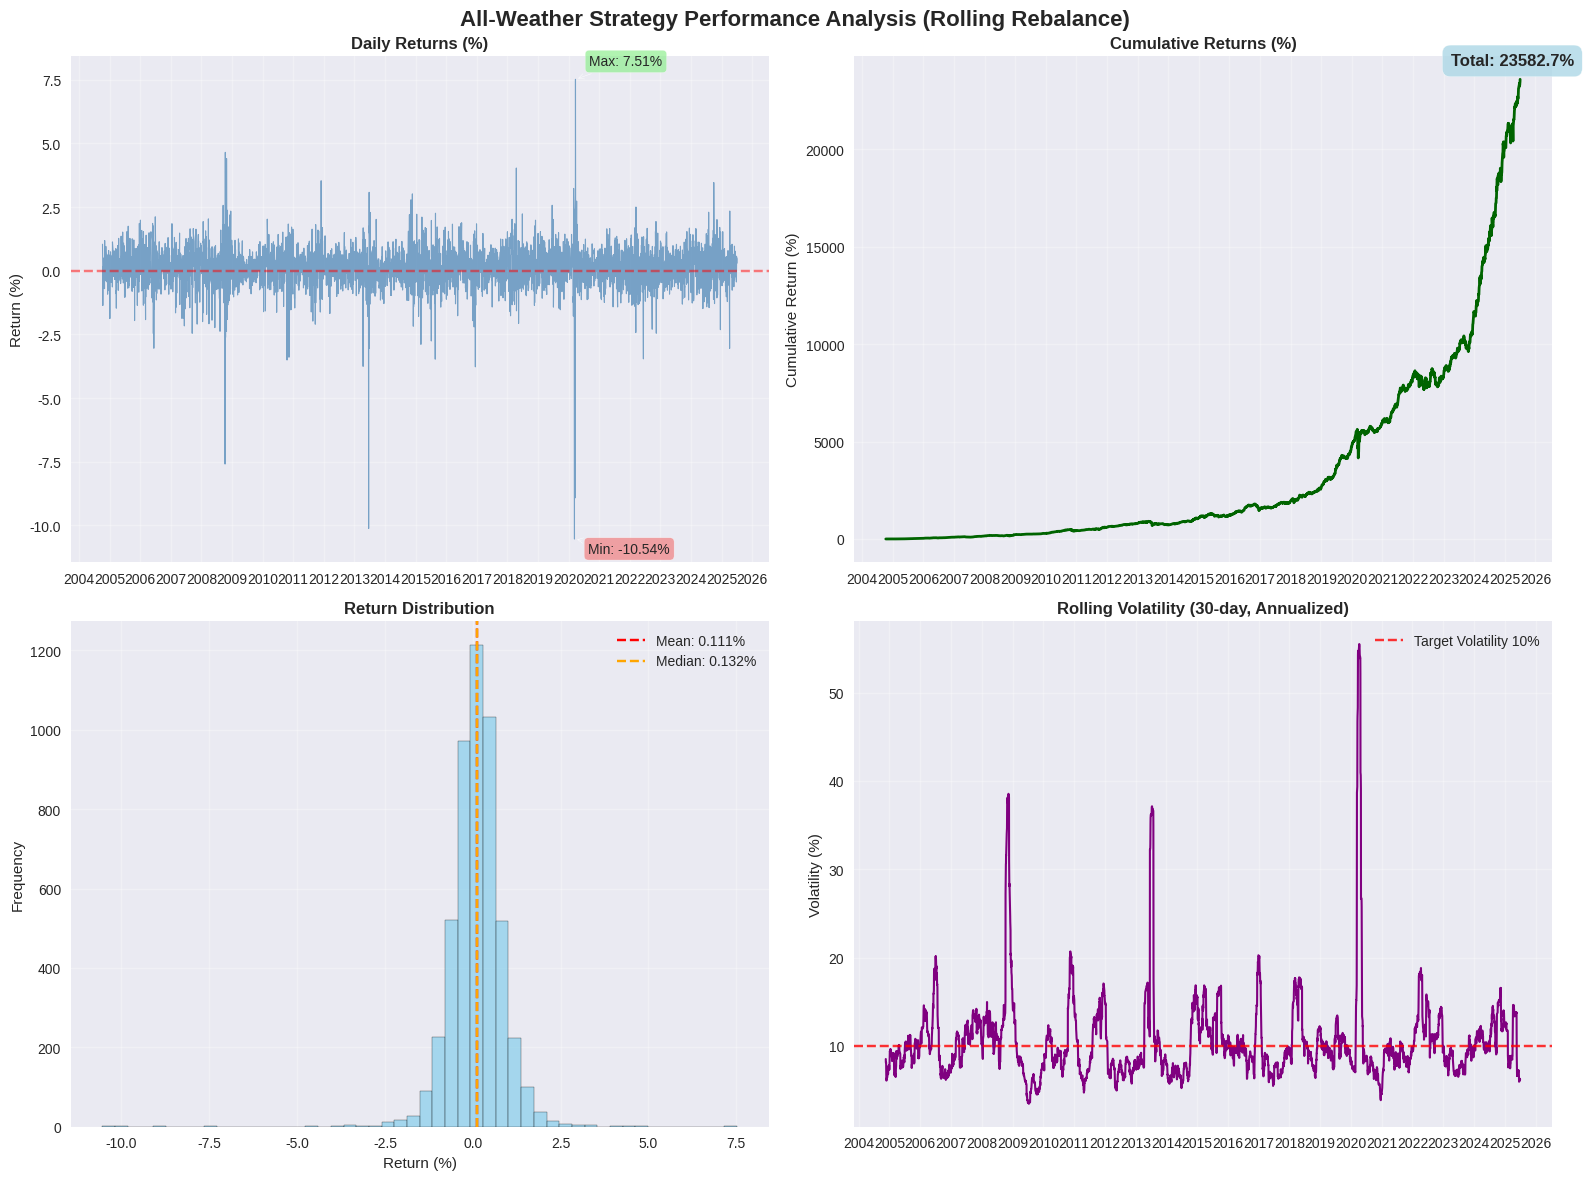


=== 滚动再平衡策略表现统计 ===
数据期间: 2004-10-08 至 2025-07-02
总交易日: 5038 天 (20.0 年)
年化收益率: 31.45%
年化波动率: 11.96%
夏普比率: 2.630
胜率: 58.6% (2950/5038)
最大单日收益: 7.51%
最大单日亏损: -10.54%
最大回撤: -25.65% (发生于 2020-03-18)
VaR (95%): -0.96%
CVaR (95%): -1.60%

结果已保存到:
  - portfolio_returns_rolling.csv (投资组合收益率)
  - weights_history_rolling.csv (权重历史记录)
  - all_weather_rolling_rebalance_analysis.png (收益率分析图)


In [7]:
import pandas as pd
import numpy as np
import yaml
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import seaborn as sns

# 设置图表样式
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8')

def calc_risk_parity_weights(cov):
    """
    计算风险平价权重

    输入:
    - cov: 协方差矩阵 (numpy.ndarray)

    输出:
    - weights: 每个资产的权重
    - risk_contributions: 每个资产的风险贡献
    """
    # 创建等风险预算向量(每个资产承担相等的风险)
    risk_budget = np.ones(len(cov)) / len(cov)

    # 计算投资组合权重
    weights = rpp.vanilla.design(cov, risk_budget)

    # 检查风险贡献
    risk_contributions = (weights @ (cov * weights)) / np.sum((weights @ (cov * weights)))

    if not np.allclose(risk_contributions, risk_budget, rtol=0.01):
        print(f"警告: 风险贡献 {risk_contributions.round(3)} 与目标风险预算 {risk_budget.round(3)} 存在差异")

    return weights, risk_contributions

def get_weights_within_environment(daily_returns, environments):
    """
    计算每个经济环境内的权重

    输入:
    - daily_returns: 日收益率数据框 (小数形式)
    - environments: 经济环境配置字典

    输出:
    - weights_within_environment: 每个环境内的权重数据框
    """
    results = []

    for environment, tickers in environments.items():
        print(f"\n计算{environment}环境内的权重...")

        # 检查指数是否在数据中
        available_tickers = [ticker for ticker in tickers if ticker in daily_returns.columns]
        if len(available_tickers) != len(tickers):
            missing = set(tickers) - set(available_tickers)
            print(f"警告: {environment}环境中缺少指数: {missing}")

        if len(available_tickers) < 2:
            print(f"警告: {environment}环境中可用指数少于2个，跳过该环境")
            continue

        # 使用原始收益率计算协方差矩阵 (对于风险平价，简单收益率和对数收益率差异不大)
        env_returns = daily_returns[available_tickers]
        cov = env_returns.cov().to_numpy()

        # 显示该环境的风险特征
        volatilities = env_returns.std() * np.sqrt(252)  # 年化波动率
        print(f"  环境内资产年化波动率: {dict(zip(available_tickers, volatilities.round(4)))}")

        # 计算风险平价权重
        weights, risk_contributions = calc_risk_parity_weights(cov)

        # 存储结果
        for i, ticker in enumerate(available_tickers):
            results.append({
                'environment': environment,
                'ticker': ticker,
                'weight': weights[i],
                'risk_contribution': risk_contributions[i]
            })

    return pd.DataFrame(results)

def get_weights_between_environments(daily_returns, weights_within_environment, environments):
    """
    计算环境间的权重

    输入:
    - daily_returns: 日收益率数据框 (小数形式)
    - weights_within_environment: 环境内权重数据框
    - environments: 经济环境配置字典

    输出:
    - weights_between_environments: 环境间权重数据框
    - environment_returns: 每个环境的收益率数据框
    """
    # 使用简单收益率进行组合加权
    daily_simple_returns = daily_returns.copy()  # 数据已经是小数形式

    # 计算每个环境的加权收益率
    environment_returns = pd.DataFrame(index=daily_returns.index)

    for environment in environments.keys():
        env_weights = weights_within_environment[
            weights_within_environment['environment'] == environment
        ]

        if len(env_weights) == 0:
            print(f"警告: {environment}环境没有有效权重，跳过")
            continue

        # 获取该环境的权重和收益率
        tickers = env_weights['ticker'].tolist()
        weights = env_weights['weight'].values

        # 确保所有指数都在收益率数据中
        available_tickers = [t for t in tickers if t in daily_simple_returns.columns]
        if len(available_tickers) != len(tickers):
            print(f"警告: {environment}环境中部分指数不可用")
            # 重新调整权重
            available_indices = [i for i, t in enumerate(tickers) if t in available_tickers]
            weights = weights[available_indices]
            weights = weights / weights.sum()  # 重新标准化
            tickers = available_tickers

        # 计算环境收益率
        env_simple_returns = daily_simple_returns[tickers]
        env_weighted_returns = env_simple_returns.to_numpy() @ weights

        environment_returns[environment] = env_weighted_returns

        # 显示环境特征
        env_volatility = pd.Series(env_weighted_returns).std() * np.sqrt(252)
        print(f"  {environment}环境年化波动率: {env_volatility:.4f}")

    # 去除缺失值
    environment_returns = environment_returns.dropna()

    if environment_returns.empty:
        raise ValueError("所有环境都无法计算有效收益率")

    print(f"\n各环境相关性矩阵:")
    correlation_matrix = environment_returns.corr()
    print(correlation_matrix.round(3))

    # 计算环境间的协方差矩阵 (这里可以直接使用简单收益率)
    cov_between = environment_returns.cov().to_numpy()

    # 计算环境间的风险平价权重
    weights, risk_contributions = calc_risk_parity_weights(cov_between)

    weights_between_environments = pd.DataFrame({
        'environment': environment_returns.columns,
        'weight': weights,
        'risk_contribution': risk_contributions
    })

    return weights_between_environments, environment_returns

def get_final_ticker_weights(weights_within_environment, weights_between_environments):
    """
    计算最终的指数权重

    输入:
    - weights_within_environment: 环境内权重
    - weights_between_environments: 环境间权重

    输出:
    - final_weights: 最终权重数据框
    """
    # 重命名列以避免冲突
    within_weights = weights_within_environment.rename(columns={"weight": "ticker_weight"})
    between_weights = weights_between_environments.rename(columns={"weight": "environment_weight"})

    # 合并数据
    merged = within_weights.merge(between_weights[['environment', 'environment_weight']],
                                 on='environment', how='left')

    # 计算最终权重
    merged['final_weight'] = merged['ticker_weight'] * merged['environment_weight']

    # 按指数汇总权重
    final_weights = merged.groupby('ticker')['final_weight'].sum().reset_index()
    final_weights = final_weights.rename(columns={'final_weight': 'weight'})

    # 确保权重总和为1
    total_weight = final_weights['weight'].sum()
    final_weights['weight'] = final_weights['weight'] / total_weight

    return final_weights


# 滚动再平衡策略函数

def rolling_rebalance_strategy(data, environments, lookback_months=1, rebalance_freq='M', target_volatility=0.15):
    """
    滚动再平衡策略 - 解决前瞻偏误问题

    修改说明：
    - 每月末使用过去lookback_months个月的数据计算权重
    - 计算出的权重应用到下个月的投资
    - 避免使用未来数据的前瞻偏误

    输入:
    - data: 收益率数据框
    - environments: 经济环境配置
    - lookback_months: 回望月数，用于计算协方差矩阵
    - rebalance_freq: 再平衡频率 ('M'=月度, 'Q'=季度)
    - target_volatility: 目标波动率

    输出:
    - portfolio_returns: 投资组合收益率时间序列
    - weights_history: 权重历史记录
    """
    print(f"\n=== 开始滚动再平衡策略 ===")
    print(f"回望期: {lookback_months}个月")
    print(f"再平衡频率: {rebalance_freq}")
    print(f"目标波动率: {target_volatility*100:.1f}%")

    # 获取再平衡日期
    if rebalance_freq == 'M':
        rebalance_dates = data.resample('M').last().index
    elif rebalance_freq == 'Q':
        rebalance_dates = data.resample('Q').last().index
    else:
        raise ValueError("再平衡频率只支持 'M' (月度) 或 'Q' (季度)")

    print(f"总共{len(rebalance_dates)}个再平衡点，从第二个季度开始执行")
    rebalance_dates = rebalance_dates[1:]

    # 存储权重历史和投资组合收益率
    weights_history = []
    portfolio_returns = pd.Series(index=data.index, dtype=float)

    current_weights = None

    for i, rebalance_date in enumerate(rebalance_dates):
        print(f"\n处理再平衡点 {i+1}/{len(rebalance_dates)}: {rebalance_date.strftime('%Y-%m-%d')}")

        # 确定历史数据窗口
        if rebalance_freq == 'M':
            start_date = rebalance_date - pd.DateOffset(months=lookback_months)
        elif rebalance_freq == 'Q':
            start_date = rebalance_date - pd.DateOffset(months=lookback_months*3)

        # 获取历史数据（不包含当前再平衡日，避免前瞻偏误）
        historical_data = data[(data.index >= start_date) & (data.index < rebalance_date)]


        try:
            # 使用历史数据计算权重
            weights_within = get_weights_within_environment(historical_data, environments)
            weights_between, _ = get_weights_between_environments(historical_data, weights_within, environments)
            final_weights = get_final_ticker_weights(weights_within, weights_between)

            print(f"\n  === 杠杆前权重分布 ===")
            final_weights_sorted = final_weights.sort_values('weight', ascending=False)
            for _, row in final_weights_sorted.iterrows():
                print(f"  {row['ticker']}: {row['weight']:.4f} ({row['weight']*100:.2f}%)")
            print(f"  权重总和: {final_weights['weight'].sum():.6f}")

            # 应用杠杆调整
            leveraged_weights, leverage_ratio, _ = apply_leverage_target_volatility(
                final_weights, historical_data, target_volatility
            )



            # 记录权重历史
            for _, row in leveraged_weights.iterrows():
                weights_history.append({
                    'date': rebalance_date,
                    'ticker': row['ticker'],
                    'weight': row['weight'],
                    'leverage_ratio': leverage_ratio
                })

            current_weights = leveraged_weights
            print(f"  成功计算权重，杠杆倍数: {leverage_ratio:.3f}x")

        except Exception as e:
            print(f"  权重计算失败: {e}")
            continue

        # 确定这次权重的应用期间
        if i < len(rebalance_dates) - 1:
            next_rebalance = rebalance_dates[i + 1]
            period_data = data[(data.index > rebalance_date) & (data.index <= next_rebalance)]
        else:
            # 最后一次再平衡，应用到数据结束
            period_data = data[data.index > rebalance_date]

        if len(period_data) == 0 or current_weights is None:
            continue

        # 计算这个期间的投资组合收益率
        period_returns, _ = calculate_portfolio_daily_returns(period_data, current_weights)
        portfolio_returns.loc[period_data.index] = period_returns

    # 移除空值
    portfolio_returns = portfolio_returns.dropna()
    weights_history_df = pd.DataFrame(weights_history)

    print(f"\n策略执行完成，有效收益率数据: {len(portfolio_returns)}天")

    return portfolio_returns, weights_history_df

def calculate_portfolio_daily_returns(data, leveraged_weights):
    """
    计算杠杆投资组合的每日收益率

    输入:
    - data: 日收益率数据框 (小数形式)
    - leveraged_weights: 杠杆后权重数据框

    输出:
    - portfolio_returns: 投资组合每日收益率序列
    - cumulative_returns: 累计收益率序列
    """
    # 确保权重顺序与数据列一致
    weight_dict = dict(zip(leveraged_weights['ticker'], leveraged_weights['weight']))
    available_tickers = [ticker for ticker in leveraged_weights['ticker'] if ticker in data.columns]

    if len(available_tickers) != len(leveraged_weights):
        print(f"警告: 部分指数在数据中不可用，实际使用: {available_tickers}")

    # 重新排列权重向量
    weights = np.array([weight_dict[ticker] for ticker in available_tickers])

    # 获取对应的收益率数据
    returns_matrix = data[available_tickers]

    # 计算每日投资组合收益率 (加权平均)
    portfolio_daily_returns = (returns_matrix * weights).sum(axis=1)

    # 计算累计收益率
    cumulative_returns = (1 + portfolio_daily_returns).cumprod() - 1

    return portfolio_daily_returns, cumulative_returns

def create_returns_visualization(portfolio_returns, cumulative_returns, data, leveraged_weights, leverage_ratio):
    """
    创建收益率可视化图表

    输入:
    - portfolio_returns: 每日收益率序列
    - cumulative_returns: 累计收益率序列
    - data: 原始数据
    - leveraged_weights: 杠杆权重
    - leverage_ratio: 杠杆倍数
    """
    # 创建图表
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'All-Weather Strategy Performance Analysis (Rolling Rebalance)', fontsize=16, fontweight='bold')

    # 1. 每日收益率时间序列
    axes[0, 0].plot(portfolio_returns.index, portfolio_returns * 100,
                    color='steelblue', alpha=0.7, linewidth=0.8)
    axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[0, 0].set_title('Daily Returns (%)', fontweight='bold')
    axes[0, 0].set_ylabel('Return (%)')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].xaxis.set_major_locator(mdates.YearLocator())
    axes[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # 标注极值
    max_return = portfolio_returns.max()
    min_return = portfolio_returns.min()
    max_date = portfolio_returns.idxmax()
    min_date = portfolio_returns.idxmin()

    axes[0, 0].annotate(f'Max: {max_return*100:.2f}%',
                        xy=(max_date, max_return*100),
                        xytext=(10, 10), textcoords='offset points',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7),
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    axes[0, 0].annotate(f'Min: {min_return*100:.2f}%',
                        xy=(min_date, min_return*100),
                        xytext=(10, -10), textcoords='offset points',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.7),
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    # 2. 累计收益率
    axes[0, 1].plot(cumulative_returns.index, cumulative_returns * 100,
                    color='darkgreen', linewidth=2)
    axes[0, 1].set_title('Cumulative Returns (%)', fontweight='bold')
    axes[0, 1].set_ylabel('Cumulative Return (%)')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].xaxis.set_major_locator(mdates.YearLocator())
    axes[0, 1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # 标注最终收益率
    final_return = cumulative_returns.iloc[-1]
    axes[0, 1].annotate(f'Total: {final_return*100:.1f}%',
                        xy=(cumulative_returns.index[-1], final_return*100),
                        xytext=(-50, 10), textcoords='offset points',
                        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8),
                        fontsize=12, fontweight='bold')

    # 3. 收益率分布直方图
    axes[1, 0].hist(portfolio_returns * 100, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1, 0].axvline(portfolio_returns.mean() * 100, color='red', linestyle='--',
                       label=f'Mean: {portfolio_returns.mean()*100:.3f}%')
    axes[1, 0].axvline(portfolio_returns.median() * 100, color='orange', linestyle='--',
                       label=f'Median: {portfolio_returns.median()*100:.3f}%')
    axes[1, 0].set_title('Return Distribution', fontweight='bold')
    axes[1, 0].set_xlabel('Return (%)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 4. 滚动波动率 (30天)
    rolling_vol = portfolio_returns.rolling(window=30).std() * np.sqrt(252) * 100
    axes[1, 1].plot(rolling_vol.index, rolling_vol, color='purple', linewidth=1.5)
    axes[1, 1].axhline(y=10, color='red', linestyle='--', alpha=0.8, label='Target Volatility 10%')
    axes[1, 1].set_title('Rolling Volatility (30-day, Annualized)', fontweight='bold')
    axes[1, 1].set_ylabel('Volatility (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].xaxis.set_major_locator(mdates.YearLocator())
    axes[1, 1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.tight_layout()
    plt.savefig('all_weather_rolling_rebalance_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 计算并显示统计指标
    print(f"\n=== 滚动再平衡策略表现统计 ===")

    # 基本统计
    total_days = len(portfolio_returns)
    years = total_days / 252
    annual_return = (1 + cumulative_returns.iloc[-1]) ** (1/years) - 1
    annual_vol = portfolio_returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_vol if annual_vol != 0 else 0

    positive_days = (portfolio_returns > 0).sum()
    negative_days = (portfolio_returns < 0).sum()
    win_rate = positive_days / total_days

    print(f"数据期间: {portfolio_returns.index[0].strftime('%Y-%m-%d')} 至 {portfolio_returns.index[-1].strftime('%Y-%m-%d')}")
    print(f"总交易日: {total_days} 天 ({years:.1f} 年)")
    print(f"年化收益率: {annual_return*100:.2f}%")
    print(f"年化波动率: {annual_vol*100:.2f}%")
    print(f"夏普比率: {sharpe_ratio:.3f}")
    print(f"胜率: {win_rate*100:.1f}% ({positive_days}/{total_days})")
    print(f"最大单日收益: {portfolio_returns.max()*100:.2f}%")
    print(f"最大单日亏损: {portfolio_returns.min()*100:.2f}%")

    # 计算最大回撤
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / (1 + peak)
    max_drawdown = drawdown.min()
    max_dd_date = drawdown.idxmin()

    print(f"最大回撤: {max_drawdown*100:.2f}% (发生于 {max_dd_date.strftime('%Y-%m-%d')})")

    # VaR和CVaR (95%置信度)
    var_95 = np.percentile(portfolio_returns, 5) * 100
    cvar_95 = portfolio_returns[portfolio_returns <= np.percentile(portfolio_returns, 5)].mean() * 100

    print(f"VaR (95%): {var_95:.2f}%")
    print(f"CVaR (95%): {cvar_95:.2f}%")

def create_asset_contribution_chart(data, leveraged_weights):
    """
    创建各资产收益贡献图
    """
    # 计算各资产的收益贡献
    weight_dict = dict(zip(leveraged_weights['ticker'], leveraged_weights['weight']))
    available_tickers = [ticker for ticker in leveraged_weights['ticker'] if ticker in data.columns]

    # 计算每日各资产收益贡献
    contributions = pd.DataFrame(index=data.index)
    for ticker in available_tickers:
        contributions[ticker] = data[ticker] * weight_dict[ticker]

    # 计算累计贡献
    cumulative_contributions = (1 + contributions).cumprod() - 1

    # 绘制累计贡献图
    plt.figure(figsize=(14, 8))

    for ticker in available_tickers:
        plt.plot(cumulative_contributions.index, cumulative_contributions[ticker] * 100,
                label=f'{ticker} (Weight: {weight_dict[ticker]*100:.1f}%)', linewidth=2)

    plt.title('Asset Cumulative Return Contributions', fontsize=16, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return Contribution (%)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.tight_layout()
    plt.savefig('asset_contributions.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 显示各资产最终贡献
    print(f"\n=== 各资产最终收益贡献 ===")
    final_contributions = cumulative_contributions.iloc[-1] * 100
    for ticker in available_tickers:
        print(f"{ticker}: {final_contributions[ticker]:.2f}% (权重: {weight_dict[ticker]*100:.1f}%)")

def calculate_portfolio_volatility(weights, data):
    """
    计算投资组合的年化波动率

    输入:
    - weights: 权重数据框，包含ticker和weight列
    - data: 收益率数据框

    输出:
    - portfolio_volatility: 年化波动率
    """
    # 确保权重顺序与数据列一致
    weight_dict = dict(zip(weights['ticker'], weights['weight']))
    available_tickers = [ticker for ticker in weights['ticker'] if ticker in data.columns]

    if len(available_tickers) != len(weights):
        print(f"警告: 部分指数在数据中不可用")

    # 重新排列权重向量
    w = np.array([weight_dict[ticker] for ticker in available_tickers])

    # 获取对应的收益率数据
    returns_matrix = data[available_tickers]

    # 计算协方差矩阵
    cov_matrix = returns_matrix.cov()

    # 计算投资组合方差
    portfolio_variance = np.dot(w, np.dot(cov_matrix, w))

    # 转换为年化波动率 (假设日收益率，252个交易日)
    portfolio_volatility = np.sqrt(portfolio_variance * 252)

    return portfolio_volatility, available_tickers

def apply_leverage_target_volatility(weights, data, target_volatility=0.15):
    """
    应用杠杆以达到目标波动率

    输入:
    - weights: 权重数据框
    - data: 收益率数据框
    - target_volatility: 目标年化波动率 (默认10%)

    输出:
    - leveraged_weights: 杠杆后的权重
    - leverage_ratio: 杠杆倍数
    - original_volatility: 原始波动率
    """
    # 计算原始投资组合波动率
    original_volatility, available_tickers = calculate_portfolio_volatility(weights, data)

    # 计算所需的杠杆倍数
    leverage_ratio = target_volatility / original_volatility

    # 应用杠杆到权重
    leveraged_weights = weights.copy()
    leveraged_weights['weight'] = leveraged_weights['weight'] * leverage_ratio
    leveraged_weights['leverage_ratio'] = leverage_ratio

    # 计算杠杆后的波动率进行验证
    leveraged_volatility, _ = calculate_portfolio_volatility(leveraged_weights, data)

    return leveraged_weights, leverage_ratio, original_volatility

def main():
    """
    主函数：计算All-Weather风险平价投资组合权重并应用杠杆
    修改说明：改为使用滚动再平衡策略，避免前瞻偏误
    """
    print("=== All-Weather风险平价投资组合权重计算 ===\n")

    # 配置目标波动率
    TARGET_VOLATILITY = 0.05  # 目标10%年化波动率

    # 配置经济环境和指数分配
    environments = {
        # 上升增长环境：股票表现好
        'RISING_GROWTH': ['881001.WI', 'HSI.HI', 'SPX.GI', 'NH0100.NHF','GC.CMX'],

        # 下降增长环境：债券表现好
        'FALLING_GROWTH': ['AGG.P', 'CBA00201.CS'],

        # 上升通胀环境：商品和黄金表现好
        'RISING_INFLATION': ['NH0100.NHF', 'GC.CMX'],

        # 下降通胀环境：股票和债券表现好
        'FALLING_INFLATION': ['881001.WI', 'HSI.HI', 'SPX.GI', 'AGG.P', 'CBA00201.CS']
    }

    print("经济环境配置:")
    for env, tickers in environments.items():
        print(f"  {env}: {tickers}")

    print(f"\n目标波动率: {TARGET_VOLATILITY*100:.1f}%")

    # 读取数据
    print(f"\n正在读取data2.csv文件...")
    try:
        # 假设CSV文件第一列是日期，其余列是各指数的收益率
        data = pd.read_csv('data2.csv', index_col=0, parse_dates=True)
        print(f"数据加载成功，形状: {data.shape}")
        print(f"日期范围: {data.index.min()} 到 {data.index.max()}")
        print(f"可用指数: {list(data.columns)}")

        # 将收益率从百分点形式转换为小数形式 (e.g., 1.0 -> 0.01)
        # 检查数据范围来推断当前格式
        data_sample = data.iloc[:100].abs()  # 取前100行的绝对值
        max_value = data_sample.max().max()

        if max_value > 1:  # 如果最大值大于1，说明是百分点形式
            print(f"检测到收益率为百分点形式 (最大值: {max_value:.2f})")
            data = data / 100.0
            print("已转换为小数形式 (1% = 0.01)")
        else:
            print(f"检测到收益率已为小数形式 (最大值: {max_value:.4f})")

        # 检查是否包含所需的指数
        all_tickers = set()
        for tickers in environments.values():
            all_tickers.update(tickers)

        missing_tickers = all_tickers - set(data.columns)
        if missing_tickers:
            print(f"\n警告: 以下指数在数据中不存在: {missing_tickers}")


        print(f"\n原始数据缺失值统计:")
        print(data.isnull().sum())

        data = data.sort_index()
        data = data.fillna(method='ffill')  # 前向填充
        data = data.fillna(method='bfill') # 后向填充，处理开头的缺失值

        print(f"填充后缺失值统计:")
        print(data.isnull().sum())
        print(f"清理后数据形状: {data.shape}")

        # 显示修正后的统计信息
        print(f"\n修正后的数据统计:")
        print(f"收益率范围: {data.min().min():.4f} 到 {data.max().max():.4f}")
        print(f"平均日收益率: {data.mean().mean():.6f}")
        print(f"平均日波动率: {data.std().mean():.6f}")

    except FileNotFoundError:
        print("错误: 找不到data.csv文件，请确保文件在当前目录下")
        return
    except Exception as e:
        print(f"读取数据时出错: {e}")
        return


    # 使用滚动再平衡策略
    print(f"\n开始执行滚动再平衡策略...")
    portfolio_returns, weights_history = rolling_rebalance_strategy(
        data=data,
        environments=environments,
        lookback_months=3,  # 使用过去3个月数据计算权重
        rebalance_freq='Q',  # 季度再平衡
        target_volatility=TARGET_VOLATILITY
    )

    if len(portfolio_returns) == 0:
        print("错误: 无法计算投资组合收益率")
        return

    # 计算累计收益率
    cumulative_returns = (1 + portfolio_returns).cumprod() - 1

    # 保存收益率数据
    returns_df = pd.DataFrame({
        'date': portfolio_returns.index,
        'daily_return': portfolio_returns,
        'cumulative_return': cumulative_returns
    })
    returns_df.to_csv('portfolio_returns_rolling.csv', index=False)
    print("投资组合收益率数据已保存到 portfolio_returns_rolling.csv")

    # 创建可视化图表
    # 使用最后一次的权重作为示例权重
    latest_weights = weights_history[weights_history['date'] == weights_history['date'].max()]
    latest_leverage = latest_weights['leverage_ratio'].iloc[0] if len(latest_weights) > 0 else 1.0

    create_returns_visualization(portfolio_returns, cumulative_returns, data,
                               latest_weights[['ticker', 'weight']], latest_leverage)

    # 保存权重历史
    weights_history.to_csv('weights_history_rolling.csv', index=False)

    print(f"\n结果已保存到:")
    print(f"  - portfolio_returns_rolling.csv (投资组合收益率)")
    print(f"  - weights_history_rolling.csv (权重历史记录)")
    print(f"  - all_weather_rolling_rebalance_analysis.png (收益率分析图)")

    return portfolio_returns, cumulative_returns, weights_history

# 运行主函数
if __name__ == "__main__":
    portfolio_returns, cumulative_returns, weights_history = main()

=== All-Weather风险平价投资组合权重计算 ===

经济环境配置:
  RISING_GROWTH: ['881001.WI', 'HSI.HI', 'SPX.GI', 'NH0100.NHF', 'GC.CMX']
  FALLING_GROWTH: ['AGG.P', 'CBA00201.CS']
  RISING_INFLATION: ['NH0100.NHF', 'GC.CMX']
  FALLING_INFLATION: ['881001.WI', 'HSI.HI', 'SPX.GI', 'AGG.P', 'CBA00201.CS']

目标波动率: 5.0%

正在读取data2.csv文件...
数据加载成功，形状: (5126, 7)
日期范围: 2004-06-01 00:00:00 到 2025-07-02 00:00:00
可用指数: ['881001.WI', 'HSI.HI', 'SPX.GI', 'AGG.P', 'CBA00201.CS', 'NH0100.NHF', 'GC.CMX']
检测到收益率为百分点形式 (最大值: 4.92)
已转换为小数形式 (1% = 0.01)

原始数据缺失值统计:
881001.WI        0
HSI.HI         156
SPX.GI         172
AGG.P          172
CBA00201.CS      0
NH0100.NHF       0
GC.CMX         171
dtype: int64
填充后缺失值统计:
881001.WI      0
HSI.HI         0
SPX.GI         0
AGG.P          0
CBA00201.CS    0
NH0100.NHF     0
GC.CMX         0
dtype: int64
清理后数据形状: (5126, 7)

修正后的数据统计:
收益率范围: -0.1322 到 0.1435
平均日收益率: 0.000303
平均日波动率: 0.009748
已对冲到人民币：识别到一年期数 py=252（用于把年化利率折算为当期carry）
各资产当期carry已保存：carry_per_asset.csv

开始执行滚动再平衡策略...



/tmp/ipython-input-48948738.py:728: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')  # 前向填充
/tmp/ipython-input-48948738.py:729: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='bfill') # 后向填充，处理开头的缺失值
/tmp/ipython-input-48948738.py:90: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  if fill_method: rb = rb.fillna(method=fill_method)
/tmp/ipython-input-48948738.py:103: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  if fill_method: rf = rf.fillna(method=fill_method)
/tmp/ipython-input-48948738.py:302: FutureWarning: 'Q' is deprecated and will be removed in a future version, pleas

                   RISING_GROWTH  FALLING_GROWTH  RISING_INFLATION  \
RISING_GROWTH              1.000          -0.031             0.678   
FALLING_GROWTH            -0.031           1.000            -0.025   
RISING_INFLATION           0.678          -0.025             1.000   
FALLING_INFLATION          0.614           0.622             0.082   

                   FALLING_INFLATION  
RISING_GROWTH                  0.614  
FALLING_GROWTH                 0.622  
RISING_INFLATION               0.082  
FALLING_INFLATION              1.000  

  === 杠杆前权重分布 ===
  CBA00201.CS: 0.4211 (42.11%)
  AGG.P: 0.3003 (30.03%)
  NH0100.NHF: 0.0749 (7.49%)
  GC.CMX: 0.0688 (6.88%)
  SPX.GI: 0.0614 (6.14%)
  HSI.HI: 0.0500 (5.00%)
  881001.WI: 0.0236 (2.36%)
  权重总和: 1.000000
  成功计算权重，杠杆倍数: 2.258x

处理再平衡点 6/85: 2005-12-31

计算RISING_GROWTH环境内的权重...
  环境内资产年化波动率: {'881001.WI': 0.2358, 'HSI.HI': 0.1105, 'SPX.GI': 0.1007, 'NH0100.NHF': 0.1088, 'GC.CMX': 0.131}

计算FALLING_GROWTH环境内的权重...
  环境内资产年化波动率: {'AGG

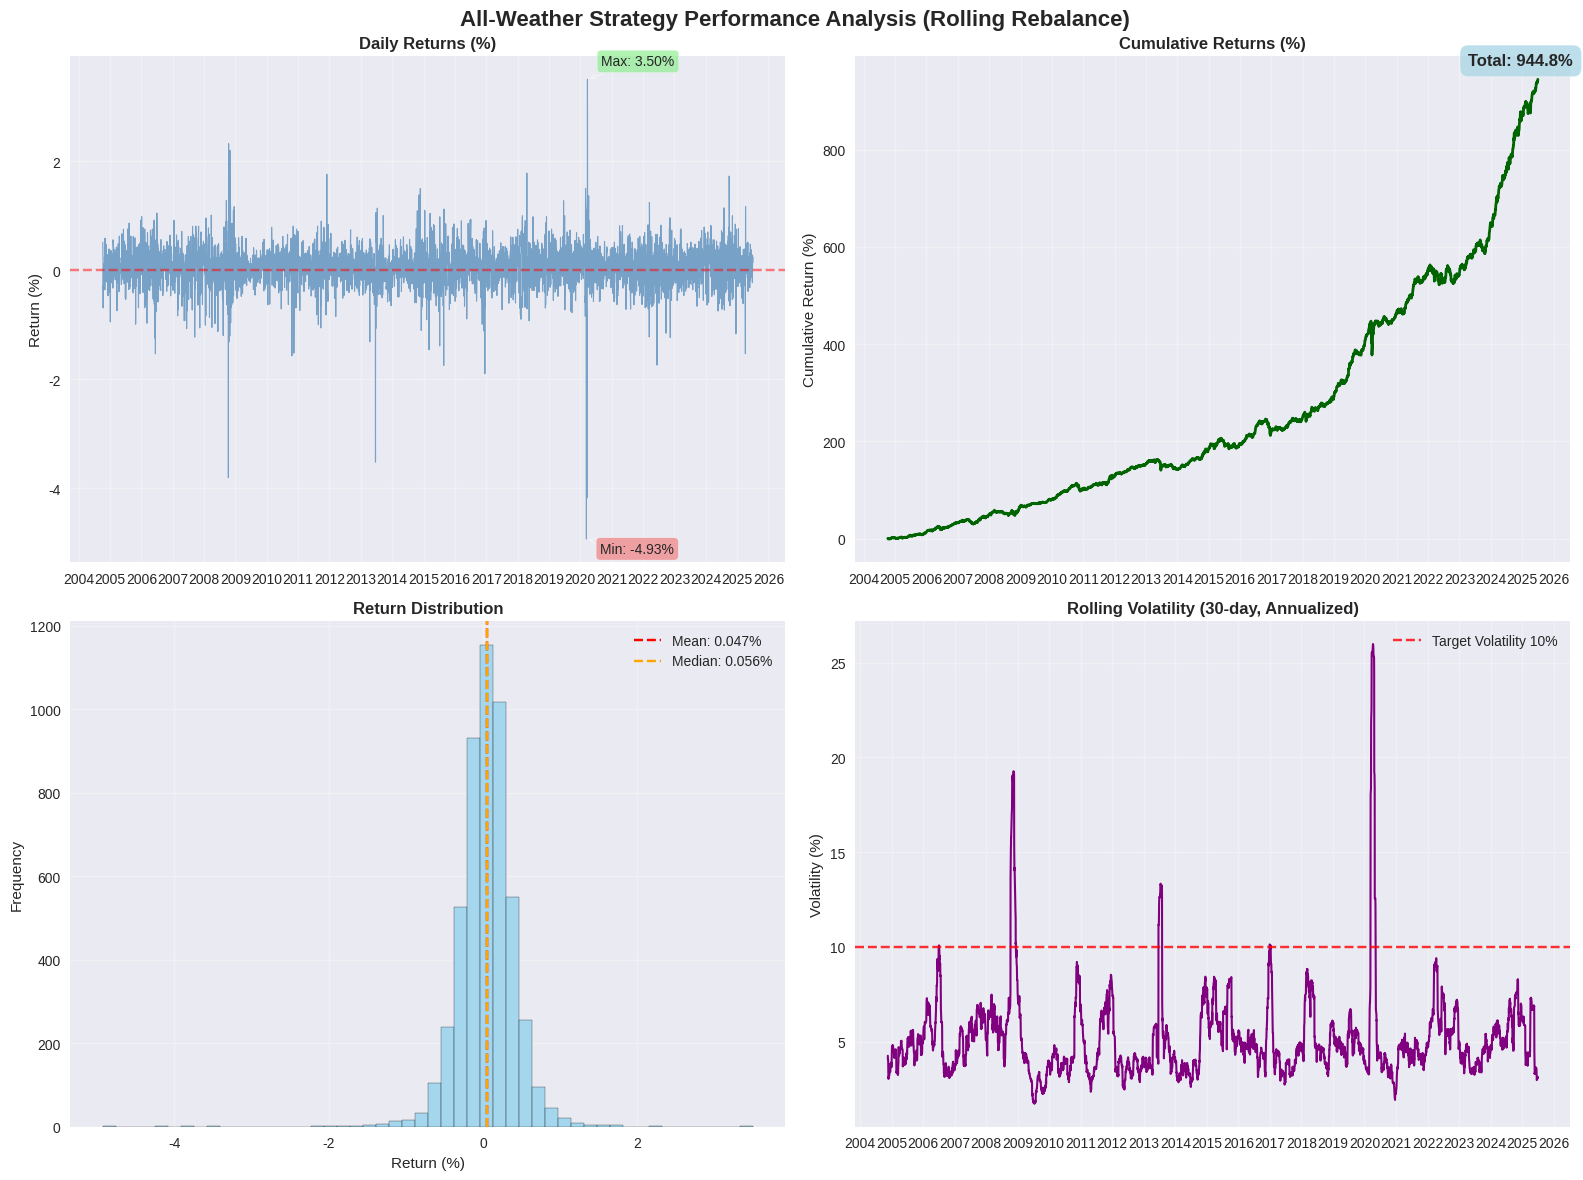


=== 滚动再平衡策略表现统计 ===
数据期间: 2004-10-08 至 2025-07-02
总交易日: 5038 天 (20.0 年)
年化收益率: 12.45%
年化波动率: 5.77%
夏普比率: 2.160
胜率: 57.5% (2896/5038)
最大单日收益: 3.50%
最大单日亏损: -4.93%
最大回撤: -12.71% (发生于 2020-03-18)
VaR (95%): -0.48%
CVaR (95%): -0.78%

结果已保存到:
  - portfolio_returns_rolling.csv (投资组合收益率)
  - weights_history_rolling.csv (权重历史记录)
  - all_weather_rolling_rebalance_analysis.png (收益率分析图)


In [14]:
import pandas as pd
import numpy as np
import yaml
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import seaborn as sns

# 设置图表样式
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8')

def calc_risk_parity_weights(cov):
    """
    计算风险平价权重

    输入:
    - cov: 协方差矩阵 (numpy.ndarray)

    输出:
    - weights: 每个资产的权重
    - risk_contributions: 每个资产的风险贡献
    """
    # 创建等风险预算向量(每个资产承担相等的风险)
    risk_budget = np.ones(len(cov)) / len(cov)

    # 计算投资组合权重
    weights = rpp.vanilla.design(cov, risk_budget)

    # 检查风险贡献
    risk_contributions = (weights @ (cov * weights)) / np.sum((weights @ (cov * weights)))

    if not np.allclose(risk_contributions, risk_budget, rtol=0.01):
        print(f"警告: 风险贡献 {risk_contributions.round(3)} 与目标风险预算 {risk_budget.round(3)} 存在差异")

    return weights, risk_contributions

# === 频率识别 + 全对冲到CNY ===
def _periods_per_year_from_index(index, fallback=252):
    """根据索引频率估计一年期数（用于把年化利率折算到当期）"""
    if len(index) < 3:
        return fallback
    freq = pd.infer_freq(index)
    if freq is None:
        # 粗估：看平均间隔
        days = (index[-1] - index[0]).days
        if days <= 0: return fallback
        avg = days / (len(index)-1)
        if avg > 20: return 12   # ~月频
        if avg > 5:  return 52   # ~周频
        return 252               # ~日频
    f = freq.upper()
    if f.startswith(('B','D')): return 252
    if f.startswith('W'):       return 52
    if f.startswith('M'):       return 12
    if f.startswith('Q'):       return 4
    if f.startswith(('A','Y')): return 1
    return fallback

def hedged_to_cny_simple(
        returns_local: pd.DataFrame,
        asset_ccy: dict,
        rate_cny: pd.Series = None,          # CNY年化（小数：0.02=2%）
        rate_foreign: dict = None,           # {'USD':series, 'EUR':series, ...} 年化利率
        periods_per_year: int = None,
        fill_method: str = 'ffill'
    ):
    """
    把本币收益变成“完全对冲到人民币”的收益（简化版）：
      r_hedged ≈ r_local + (i_CNY - i_ccy)/py
    返回：
      returns_hedged：DataFrame，各资产已对冲到CNY的简单收益
      carry_df：DataFrame，各资产当期的carry
      py：识别到的一年期数（252/52/12/...）
    """
    r_local = returns_local.copy()
    idx = r_local.index

    if periods_per_year is None:
        periods_per_year = _periods_per_year_from_index(idx)

    # CNY利率
    if rate_cny is None:
        rb = pd.Series(0.0, index=idx)
    else:
        rb = rate_cny.reindex(idx)
        if fill_method: rb = rb.fillna(method=fill_method)
        rb = rb.fillna(0.0)

    rate_foreign = rate_foreign or {}

    out = {}
    carry_detail = {}
    for t in r_local.columns:
        ccy = asset_ccy.get(t, 'CNY')
        if ccy == 'CNY':
            carry_t = pd.Series(0.0, index=idx)
        else:
            rf = rate_foreign.get(ccy, pd.Series(0.0, index=idx)).reindex(idx)
            if fill_method: rf = rf.fillna(method=fill_method)
            rf = rf.fillna(0.0)
            carry_t = (rb - rf) / periods_per_year
        out[t] = r_local[t] + carry_t
        carry_detail[t] = carry_t

    returns_hedged = pd.DataFrame(out, index=idx)
    carry_df = pd.DataFrame(carry_detail, index=idx)
    return returns_hedged, carry_df, periods_per_year


def get_weights_within_environment(daily_returns, environments):
    """
    计算每个经济环境内的权重

    输入:
    - daily_returns: 日收益率数据框 (小数形式)
    - environments: 经济环境配置字典

    输出:
    - weights_within_environment: 每个环境内的权重数据框
    """
    results = []

    for environment, tickers in environments.items():
        print(f"\n计算{environment}环境内的权重...")

        # 检查指数是否在数据中
        available_tickers = [ticker for ticker in tickers if ticker in daily_returns.columns]
        if len(available_tickers) != len(tickers):
            missing = set(tickers) - set(available_tickers)
            print(f"警告: {environment}环境中缺少指数: {missing}")

        if len(available_tickers) < 2:
            print(f"警告: {environment}环境中可用指数少于2个，跳过该环境")
            continue

        # 使用原始收益率计算协方差矩阵 (对于风险平价，简单收益率和对数收益率差异不大)
        env_returns = daily_returns[available_tickers]
        cov = env_returns.cov().to_numpy()

        # 显示该环境的风险特征
        volatilities = env_returns.std() * np.sqrt(252)  # 年化波动率
        print(f"  环境内资产年化波动率: {dict(zip(available_tickers, volatilities.round(4)))}")

        # 计算风险平价权重
        weights, risk_contributions = calc_risk_parity_weights(cov)

        # 存储结果
        for i, ticker in enumerate(available_tickers):
            results.append({
                'environment': environment,
                'ticker': ticker,
                'weight': weights[i],
                'risk_contribution': risk_contributions[i]
            })

    return pd.DataFrame(results)

def get_weights_between_environments(daily_returns, weights_within_environment, environments):
    """
    计算环境间的权重

    输入:
    - daily_returns: 日收益率数据框 (小数形式)
    - weights_within_environment: 环境内权重数据框
    - environments: 经济环境配置字典

    输出:
    - weights_between_environments: 环境间权重数据框
    - environment_returns: 每个环境的收益率数据框
    """
    # 使用简单收益率进行组合加权
    daily_simple_returns = daily_returns.copy()  # 数据已经是小数形式

    # 计算每个环境的加权收益率
    environment_returns = pd.DataFrame(index=daily_returns.index)

    for environment in environments.keys():
        env_weights = weights_within_environment[
            weights_within_environment['environment'] == environment
        ]

        if len(env_weights) == 0:
            print(f"警告: {environment}环境没有有效权重，跳过")
            continue

        # 获取该环境的权重和收益率
        tickers = env_weights['ticker'].tolist()
        weights = env_weights['weight'].values

        # 确保所有指数都在收益率数据中
        available_tickers = [t for t in tickers if t in daily_simple_returns.columns]
        if len(available_tickers) != len(tickers):
            print(f"警告: {environment}环境中部分指数不可用")
            # 重新调整权重
            available_indices = [i for i, t in enumerate(tickers) if t in available_tickers]
            weights = weights[available_indices]
            weights = weights / weights.sum()  # 重新标准化
            tickers = available_tickers

        # 计算环境收益率
        env_simple_returns = daily_simple_returns[tickers]
        env_weighted_returns = env_simple_returns.to_numpy() @ weights

        environment_returns[environment] = env_weighted_returns

        # 显示环境特征
        env_volatility = pd.Series(env_weighted_returns).std() * np.sqrt(252)
        print(f"  {environment}环境年化波动率: {env_volatility:.4f}")

    # 去除缺失值
    environment_returns = environment_returns.dropna()

    if environment_returns.empty:
        raise ValueError("所有环境都无法计算有效收益率")

    print(f"\n各环境相关性矩阵:")
    correlation_matrix = environment_returns.corr()
    print(correlation_matrix.round(3))

    # 计算环境间的协方差矩阵 (这里可以直接使用简单收益率)
    cov_between = environment_returns.cov().to_numpy()

    # 计算环境间的风险平价权重
    weights, risk_contributions = calc_risk_parity_weights(cov_between)

    weights_between_environments = pd.DataFrame({
        'environment': environment_returns.columns,
        'weight': weights,
        'risk_contribution': risk_contributions
    })

    return weights_between_environments, environment_returns

def get_final_ticker_weights(weights_within_environment, weights_between_environments):
    """
    计算最终的指数权重

    输入:
    - weights_within_environment: 环境内权重
    - weights_between_environments: 环境间权重

    输出:
    - final_weights: 最终权重数据框
    """
    # 重命名列以避免冲突
    within_weights = weights_within_environment.rename(columns={"weight": "ticker_weight"})
    between_weights = weights_between_environments.rename(columns={"weight": "environment_weight"})

    # 合并数据
    merged = within_weights.merge(between_weights[['environment', 'environment_weight']],
                                 on='environment', how='left')

    # 计算最终权重
    merged['final_weight'] = merged['ticker_weight'] * merged['environment_weight']

    # 按指数汇总权重
    final_weights = merged.groupby('ticker')['final_weight'].sum().reset_index()
    final_weights = final_weights.rename(columns={'final_weight': 'weight'})

    # 确保权重总和为1
    total_weight = final_weights['weight'].sum()
    final_weights['weight'] = final_weights['weight'] / total_weight

    return final_weights


# 滚动再平衡策略函数

def rolling_rebalance_strategy(data, environments, lookback_months=1, rebalance_freq='M', target_volatility=0.15):
    """
    滚动再平衡策略 - 解决前瞻偏误问题

    修改说明：
    - 每月末使用过去lookback_months个月的数据计算权重
    - 计算出的权重应用到下个月的投资
    - 避免使用未来数据的前瞻偏误

    输入:
    - data: 收益率数据框
    - environments: 经济环境配置
    - lookback_months: 回望月数，用于计算协方差矩阵
    - rebalance_freq: 再平衡频率 ('M'=月度, 'Q'=季度)
    - target_volatility: 目标波动率

    输出:
    - portfolio_returns: 投资组合收益率时间序列
    - weights_history: 权重历史记录
    """
    print(f"\n=== 开始滚动再平衡策略 ===")
    print(f"回望期: {lookback_months}个月")
    print(f"再平衡频率: {rebalance_freq}")
    print(f"目标波动率: {target_volatility*100:.1f}%")

    # 获取再平衡日期
    if rebalance_freq == 'M':
        rebalance_dates = data.resample('M').last().index
    elif rebalance_freq == 'Q':
        rebalance_dates = data.resample('Q').last().index
    else:
        raise ValueError("再平衡频率只支持 'M' (月度) 或 'Q' (季度)")

    print(f"总共{len(rebalance_dates)}个再平衡点，从第二个季度开始执行")
    rebalance_dates = rebalance_dates[1:]

    # 存储权重历史和投资组合收益率
    weights_history = []
    portfolio_returns = pd.Series(index=data.index, dtype=float)

    current_weights = None

    for i, rebalance_date in enumerate(rebalance_dates):
        print(f"\n处理再平衡点 {i+1}/{len(rebalance_dates)}: {rebalance_date.strftime('%Y-%m-%d')}")

        # 确定历史数据窗口
        if rebalance_freq == 'M':
            start_date = rebalance_date - pd.DateOffset(months=lookback_months)
        elif rebalance_freq == 'Q':
            start_date = rebalance_date - pd.DateOffset(months=lookback_months*3)

        # 获取历史数据（不包含当前再平衡日，避免前瞻偏误）
        historical_data = data[(data.index >= start_date) & (data.index < rebalance_date)]


        try:
            # 使用历史数据计算权重
            weights_within = get_weights_within_environment(historical_data, environments)
            weights_between, _ = get_weights_between_environments(historical_data, weights_within, environments)
            final_weights = get_final_ticker_weights(weights_within, weights_between)

            print(f"\n  === 杠杆前权重分布 ===")
            final_weights_sorted = final_weights.sort_values('weight', ascending=False)
            for _, row in final_weights_sorted.iterrows():
                print(f"  {row['ticker']}: {row['weight']:.4f} ({row['weight']*100:.2f}%)")
            print(f"  权重总和: {final_weights['weight'].sum():.6f}")

            # 应用杠杆调整
            leveraged_weights, leverage_ratio, _ = apply_leverage_target_volatility(
                final_weights, historical_data, target_volatility
            )



            # 记录权重历史
            for _, row in leveraged_weights.iterrows():
                weights_history.append({
                    'date': rebalance_date,
                    'ticker': row['ticker'],
                    'weight': row['weight'],
                    'leverage_ratio': leverage_ratio
                })

            current_weights = leveraged_weights
            print(f"  成功计算权重，杠杆倍数: {leverage_ratio:.3f}x")

        except Exception as e:
            print(f"  权重计算失败: {e}")
            continue

        # 确定这次权重的应用期间
        if i < len(rebalance_dates) - 1:
            next_rebalance = rebalance_dates[i + 1]
            period_data = data[(data.index > rebalance_date) & (data.index <= next_rebalance)]
        else:
            # 最后一次再平衡，应用到数据结束
            period_data = data[data.index > rebalance_date]

        if len(period_data) == 0 or current_weights is None:
            continue

        # 计算这个期间的投资组合收益率
        period_returns, _ = calculate_portfolio_daily_returns(period_data, current_weights)
        portfolio_returns.loc[period_data.index] = period_returns

    # 移除空值
    portfolio_returns = portfolio_returns.dropna()
    weights_history_df = pd.DataFrame(weights_history)

    print(f"\n策略执行完成，有效收益率数据: {len(portfolio_returns)}天")

    return portfolio_returns, weights_history_df

def calculate_portfolio_daily_returns(data, leveraged_weights):
    """
    计算杠杆投资组合的每日收益率

    输入:
    - data: 日收益率数据框 (小数形式)
    - leveraged_weights: 杠杆后权重数据框

    输出:
    - portfolio_returns: 投资组合每日收益率序列
    - cumulative_returns: 累计收益率序列
    """
    # 确保权重顺序与数据列一致
    weight_dict = dict(zip(leveraged_weights['ticker'], leveraged_weights['weight']))
    available_tickers = [ticker for ticker in leveraged_weights['ticker'] if ticker in data.columns]

    if len(available_tickers) != len(leveraged_weights):
        print(f"警告: 部分指数在数据中不可用，实际使用: {available_tickers}")

    # 重新排列权重向量
    weights = np.array([weight_dict[ticker] for ticker in available_tickers])

    # 获取对应的收益率数据
    returns_matrix = data[available_tickers]

    # 计算每日投资组合收益率 (加权平均)
    portfolio_daily_returns = (returns_matrix * weights).sum(axis=1)

    # 计算累计收益率
    cumulative_returns = (1 + portfolio_daily_returns).cumprod() - 1

    return portfolio_daily_returns, cumulative_returns

def create_returns_visualization(portfolio_returns, cumulative_returns, data, leveraged_weights, leverage_ratio):
    """
    创建收益率可视化图表

    输入:
    - portfolio_returns: 每日收益率序列
    - cumulative_returns: 累计收益率序列
    - data: 原始数据
    - leveraged_weights: 杠杆权重
    - leverage_ratio: 杠杆倍数
    """
    # 创建图表
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'All-Weather Strategy Performance Analysis (Rolling Rebalance)', fontsize=16, fontweight='bold')

    # 1. 每日收益率时间序列
    axes[0, 0].plot(portfolio_returns.index, portfolio_returns * 100,
                    color='steelblue', alpha=0.7, linewidth=0.8)
    axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[0, 0].set_title('Daily Returns (%)', fontweight='bold')
    axes[0, 0].set_ylabel('Return (%)')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].xaxis.set_major_locator(mdates.YearLocator())
    axes[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # 标注极值
    max_return = portfolio_returns.max()
    min_return = portfolio_returns.min()
    max_date = portfolio_returns.idxmax()
    min_date = portfolio_returns.idxmin()

    axes[0, 0].annotate(f'Max: {max_return*100:.2f}%',
                        xy=(max_date, max_return*100),
                        xytext=(10, 10), textcoords='offset points',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7),
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    axes[0, 0].annotate(f'Min: {min_return*100:.2f}%',
                        xy=(min_date, min_return*100),
                        xytext=(10, -10), textcoords='offset points',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.7),
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    # 2. 累计收益率
    axes[0, 1].plot(cumulative_returns.index, cumulative_returns * 100,
                    color='darkgreen', linewidth=2)
    axes[0, 1].set_title('Cumulative Returns (%)', fontweight='bold')
    axes[0, 1].set_ylabel('Cumulative Return (%)')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].xaxis.set_major_locator(mdates.YearLocator())
    axes[0, 1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # 标注最终收益率
    final_return = cumulative_returns.iloc[-1]
    axes[0, 1].annotate(f'Total: {final_return*100:.1f}%',
                        xy=(cumulative_returns.index[-1], final_return*100),
                        xytext=(-50, 10), textcoords='offset points',
                        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8),
                        fontsize=12, fontweight='bold')

    # 3. 收益率分布直方图
    axes[1, 0].hist(portfolio_returns * 100, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1, 0].axvline(portfolio_returns.mean() * 100, color='red', linestyle='--',
                       label=f'Mean: {portfolio_returns.mean()*100:.3f}%')
    axes[1, 0].axvline(portfolio_returns.median() * 100, color='orange', linestyle='--',
                       label=f'Median: {portfolio_returns.median()*100:.3f}%')
    axes[1, 0].set_title('Return Distribution', fontweight='bold')
    axes[1, 0].set_xlabel('Return (%)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 4. 滚动波动率 (30天)
    rolling_vol = portfolio_returns.rolling(window=30).std() * np.sqrt(252) * 100
    axes[1, 1].plot(rolling_vol.index, rolling_vol, color='purple', linewidth=1.5)
    axes[1, 1].axhline(y=10, color='red', linestyle='--', alpha=0.8, label='Target Volatility 10%')
    axes[1, 1].set_title('Rolling Volatility (30-day, Annualized)', fontweight='bold')
    axes[1, 1].set_ylabel('Volatility (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].xaxis.set_major_locator(mdates.YearLocator())
    axes[1, 1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.tight_layout()
    plt.savefig('all_weather_rolling_rebalance_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 计算并显示统计指标
    print(f"\n=== 滚动再平衡策略表现统计 ===")

    # 基本统计
    total_days = len(portfolio_returns)
    years = total_days / 252
    annual_return = (1 + cumulative_returns.iloc[-1]) ** (1/years) - 1
    annual_vol = portfolio_returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_vol if annual_vol != 0 else 0

    positive_days = (portfolio_returns > 0).sum()
    negative_days = (portfolio_returns < 0).sum()
    win_rate = positive_days / total_days

    print(f"数据期间: {portfolio_returns.index[0].strftime('%Y-%m-%d')} 至 {portfolio_returns.index[-1].strftime('%Y-%m-%d')}")
    print(f"总交易日: {total_days} 天 ({years:.1f} 年)")
    print(f"年化收益率: {annual_return*100:.2f}%")
    print(f"年化波动率: {annual_vol*100:.2f}%")
    print(f"夏普比率: {sharpe_ratio:.3f}")
    print(f"胜率: {win_rate*100:.1f}% ({positive_days}/{total_days})")
    print(f"最大单日收益: {portfolio_returns.max()*100:.2f}%")
    print(f"最大单日亏损: {portfolio_returns.min()*100:.2f}%")

    # 计算最大回撤
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / (1 + peak)
    max_drawdown = drawdown.min()
    max_dd_date = drawdown.idxmin()

    print(f"最大回撤: {max_drawdown*100:.2f}% (发生于 {max_dd_date.strftime('%Y-%m-%d')})")

    # VaR和CVaR (95%置信度)
    var_95 = np.percentile(portfolio_returns, 5) * 100
    cvar_95 = portfolio_returns[portfolio_returns <= np.percentile(portfolio_returns, 5)].mean() * 100

    print(f"VaR (95%): {var_95:.2f}%")
    print(f"CVaR (95%): {cvar_95:.2f}%")

def create_asset_contribution_chart(data, leveraged_weights):
    """
    创建各资产收益贡献图
    """
    # 计算各资产的收益贡献
    weight_dict = dict(zip(leveraged_weights['ticker'], leveraged_weights['weight']))
    available_tickers = [ticker for ticker in leveraged_weights['ticker'] if ticker in data.columns]

    # 计算每日各资产收益贡献
    contributions = pd.DataFrame(index=data.index)
    for ticker in available_tickers:
        contributions[ticker] = data[ticker] * weight_dict[ticker]

    # 计算累计贡献
    cumulative_contributions = (1 + contributions).cumprod() - 1

    # 绘制累计贡献图
    plt.figure(figsize=(14, 8))

    for ticker in available_tickers:
        plt.plot(cumulative_contributions.index, cumulative_contributions[ticker] * 100,
                label=f'{ticker} (Weight: {weight_dict[ticker]*100:.1f}%)', linewidth=2)

    plt.title('Asset Cumulative Return Contributions', fontsize=16, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return Contribution (%)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.tight_layout()
    plt.savefig('asset_contributions.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 显示各资产最终贡献
    print(f"\n=== 各资产最终收益贡献 ===")
    final_contributions = cumulative_contributions.iloc[-1] * 100
    for ticker in available_tickers:
        print(f"{ticker}: {final_contributions[ticker]:.2f}% (权重: {weight_dict[ticker]*100:.1f}%)")

def calculate_portfolio_volatility(weights, data):
    """
    计算投资组合的年化波动率

    输入:
    - weights: 权重数据框，包含ticker和weight列
    - data: 收益率数据框

    输出:
    - portfolio_volatility: 年化波动率
    """
    # 确保权重顺序与数据列一致
    weight_dict = dict(zip(weights['ticker'], weights['weight']))
    available_tickers = [ticker for ticker in weights['ticker'] if ticker in data.columns]

    if len(available_tickers) != len(weights):
        print(f"警告: 部分指数在数据中不可用")

    # 重新排列权重向量
    w = np.array([weight_dict[ticker] for ticker in available_tickers])

    # 获取对应的收益率数据
    returns_matrix = data[available_tickers]

    # 计算协方差矩阵
    cov_matrix = returns_matrix.cov()

    # 计算投资组合方差
    portfolio_variance = np.dot(w, np.dot(cov_matrix, w))

    # 转换为年化波动率 (假设日收益率，252个交易日)
    portfolio_volatility = np.sqrt(portfolio_variance * 252)

    return portfolio_volatility, available_tickers

def apply_leverage_target_volatility(weights, data, target_volatility=0.15,
                                     max_leverage=4.0, eps=1e-12):
    """
    应用杠杆以达到目标波动率，并且不超过 max_leverage（默认4倍）

    输入:
    - weights: 权重DataFrame，含 ['ticker','weight']
    - data: 收益率DataFrame
    - target_volatility: 目标年化波动率（如0.10=10%）
    - max_leverage: 杠杆上限（默认4.0）
    - eps: 防止除零

    输出:
    - leveraged_weights: 加杠杆后的权重（附带诊断列）
    - leverage_ratio: 实际使用的杠杆倍数（已截断）
    - original_volatility: 原始组合年化波动率
    """
    # 计算原始波动率
    original_volatility, _ = calculate_portfolio_volatility(weights, data)

    # 处理极端情况
    if (original_volatility is None) or (not np.isfinite(original_volatility)) or (original_volatility < eps):
        # 无法估出波动/过小：不加杠杆
        leverage_raw = 0.0
        leverage_ratio = 0.0
    else:
        leverage_raw = target_volatility / original_volatility
        # 将杠杆限制在 [0, max_leverage]
        leverage_ratio = np.clip(leverage_raw, 0.0, max_leverage)

    # 应用杠杆
    leveraged_weights = weights.copy()
    leveraged_weights['weight'] = leveraged_weights['weight'] * leverage_ratio

    # 诊断信息：记录实际与原始杠杆、是否被截断
    leveraged_weights['leverage_ratio'] = leverage_ratio
    leveraged_weights['leverage_ratio_raw'] = leverage_raw
    leveraged_weights['is_capped'] = leverage_ratio < leverage_raw - 1e-12

    return leveraged_weights, leverage_ratio, original_volatility


def main():
    """
    主函数：计算All-Weather风险平价投资组合权重并应用杠杆
    修改说明：改为使用滚动再平衡策略，避免前瞻偏误
    """
    print("=== All-Weather风险平价投资组合权重计算 ===\n")

    # 配置目标波动率
    TARGET_VOLATILITY = 0.05  # 目标10%年化波动率

    # 配置经济环境和指数分配
    environments = {
        # 上升增长环境：股票表现好
        'RISING_GROWTH': ['881001.WI', 'HSI.HI', 'SPX.GI', 'NH0100.NHF','GC.CMX'],

        # 下降增长环境：债券表现好
        'FALLING_GROWTH': ['AGG.P', 'CBA00201.CS'],

        # 上升通胀环境：商品和黄金表现好
        'RISING_INFLATION': ['NH0100.NHF', 'GC.CMX'],

        # 下降通胀环境：股票和债券表现好
        'FALLING_INFLATION': ['881001.WI', 'HSI.HI', 'SPX.GI', 'AGG.P', 'CBA00201.CS']
    }

    print("经济环境配置:")
    for env, tickers in environments.items():
        print(f"  {env}: {tickers}")

    print(f"\n目标波动率: {TARGET_VOLATILITY*100:.1f}%")

    # 读取数据
    print(f"\n正在读取data2.csv文件...")
    try:
        # 假设CSV文件第一列是日期，其余列是各指数的收益率
        data = pd.read_csv('data2.csv', index_col=0, parse_dates=True)
        print(f"数据加载成功，形状: {data.shape}")
        print(f"日期范围: {data.index.min()} 到 {data.index.max()}")
        print(f"可用指数: {list(data.columns)}")

        # 将收益率从百分点形式转换为小数形式 (e.g., 1.0 -> 0.01)
        # 检查数据范围来推断当前格式
        data_sample = data.iloc[:100].abs()  # 取前100行的绝对值
        max_value = data_sample.max().max()

        if max_value > 1:  # 如果最大值大于1，说明是百分点形式
            print(f"检测到收益率为百分点形式 (最大值: {max_value:.2f})")
            data = data / 100.0
            print("已转换为小数形式 (1% = 0.01)")
        else:
            print(f"检测到收益率已为小数形式 (最大值: {max_value:.4f})")

        # 检查是否包含所需的指数
        all_tickers = set()
        for tickers in environments.values():
            all_tickers.update(tickers)

        missing_tickers = all_tickers - set(data.columns)
        if missing_tickers:
            print(f"\n警告: 以下指数在数据中不存在: {missing_tickers}")


        print(f"\n原始数据缺失值统计:")
        print(data.isnull().sum())

        data = data.sort_index()
        data = data.fillna(method='ffill')  # 前向填充
        data = data.fillna(method='bfill') # 后向填充，处理开头的缺失值

        print(f"填充后缺失值统计:")
        print(data.isnull().sum())
        print(f"清理后数据形状: {data.shape}")

        # 显示修正后的统计信息
        print(f"\n修正后的数据统计:")
        print(f"收益率范围: {data.min().min():.4f} 到 {data.max().max():.4f}")
        print(f"平均日收益率: {data.mean().mean():.6f}")
        print(f"平均日波动率: {data.std().mean():.6f}")

    except FileNotFoundError:
        print("错误: 找不到data.csv文件，请确保文件在当前目录下")
        return
    except Exception as e:
        print(f"读取数据时出错: {e}")
        return

        # === Step A：定义各资产计价货币（请按实际核对）===
    asset_ccy = {
        'SPX.GI': 'USD',     # 标普
        'HSI.HI': 'HKD',     # 恒生
        'GC.CMX': 'USD',     # 黄金（COMEX）
        'AGG.P' : 'USD',     # 美债/投资级债综合
        '881001.WI': 'CNY',  # 中证全指（示例）
        'CBA00201.CS': 'CNY',# 中债指数（示例）
        'NH0100.NHF': 'CNY', # 这条请按你的数据源核实；不确定就先CNY
    }

    # === Step B：准备利率（没有真实利率也能跑，先用0占位）===
    # 1) 人民币短端利率（年化，小数）。有序列就放进来；没有就None（函数会当成0）
    # 说明：
    # - CNY：用 DR007（银行间7天质押式回购）作人民币短端代理，近期 ~1.5%
    # - USD：用 SOFR（美元担保隔夜融资利率）作美元短端代理，2025-10 附近 ~3.9%~4.0%
    # - HKD：用香港金管局 Base Rate 作为港元短端代理，2025-10-30 调整至 4.25%

    rate_cny = pd.Series(0.0150, index=data.index)    # CNY 约 1.50%

    rate_fx = {
        'USD': pd.Series(0.0390, index=data.index),   # USD 约 3.90%（SOFR 水平）
        'HKD': pd.Series(0.0425, index=data.index),   # HKD 约 4.25%（Base Rate）
    }

    # === Step C：把本币收益转成“已对冲到人民币”的收益（简化全对冲）===
    returns_hedged_cny, carry_df, py = hedged_to_cny_simple(
        returns_local=data,
        asset_ccy=asset_ccy,
        rate_cny=rate_cny,
        rate_foreign=rate_fx
    )
    print(f"已对冲到人民币：识别到一年期数 py={py}（用于把年化利率折算为当期carry）")
    carry_df.to_csv('carry_per_asset.csv')
    print("各资产当期carry已保存：carry_per_asset.csv")

    # 用已对冲的收益进入后续流程
    data_used = returns_hedged_cny

    # 使用滚动再平衡策略
    print(f"\n开始执行滚动再平衡策略...")
    portfolio_returns, weights_history = rolling_rebalance_strategy(
        data=data_used,   # <<<<<< 使用“已对冲到人民币”的收益
        environments=environments,
        lookback_months=3,
        rebalance_freq='Q',
        target_volatility=TARGET_VOLATILITY
    )


    if len(portfolio_returns) == 0:
        print("错误: 无法计算投资组合收益率")
        return

    # 计算累计收益率
    cumulative_returns = (1 + portfolio_returns).cumprod() - 1

    # 保存收益率数据
    returns_df = pd.DataFrame({
        'date': portfolio_returns.index,
        'daily_return': portfolio_returns,
        'cumulative_return': cumulative_returns
    })
    returns_df.to_csv('portfolio_returns_rolling.csv', index=False)
    print("投资组合收益率数据已保存到 portfolio_returns_rolling.csv")

    # 创建可视化图表
    # 使用最后一次的权重作为示例权重
    latest_weights = weights_history[weights_history['date'] == weights_history['date'].max()]
    latest_leverage = latest_weights['leverage_ratio'].iloc[0] if len(latest_weights) > 0 else 1.0

    create_returns_visualization(portfolio_returns, cumulative_returns, data,
                               latest_weights[['ticker', 'weight']], latest_leverage)

    # 保存权重历史
    weights_history.to_csv('weights_history_rolling.csv', index=False)

    print(f"\n结果已保存到:")
    print(f"  - portfolio_returns_rolling.csv (投资组合收益率)")
    print(f"  - weights_history_rolling.csv (权重历史记录)")
    print(f"  - all_weather_rolling_rebalance_analysis.png (收益率分析图)")

    return portfolio_returns, cumulative_returns, weights_history

# 运行主函数
if __name__ == "__main__":
    portfolio_returns, cumulative_returns, weights_history = main()